In this notebook we're going to paramterize a word2vec model with tokens.

In [1]:
from pathlib import Path

scratch = Path("~/scratch/birdclef/2025").expanduser()
! ls {scratch}/mel2vec
! ls {scratch}/mel2vec/embedding
! ls {scratch}/mel2vec/embedding/train

embedding  tokenizer  tokenizer_pca  word2vec
soundscape  train


'tokenizer=tokenizer'  'tokenizer=tokenizer_pca'


Let's read the the train embedding stuff and make sure that it looks reasonable.

In [30]:
import polars as pl

df = (
    pl.read_parquet(
        f"{scratch}/mel2vec/embedding/train/**/*.parquet", hive_partitioning=True
    )
    .sort("file", "start_time")
    .with_columns(
        species=pl.col("file").str.split("/").list.get(-2),
        track=pl.col("file").str.split("/").list.get(-1).str.split(".").list.first(),
    )
)
display(df)
df.count()

file,start_time,mfcc_stats,word_vector,tokenizer,vector_size,window,ns_exponent,sample,epochs,species,track
str,i32,list[f32],list[f32],str,i64,i64,f64,f64,i64,str,str
"""/storage/coda1/p-dsgt_clef2025…",0,"[6.5953e-10, -4.6724e-10, … 5.5262e-11]","[0.427506, -0.509639, … -0.919637]","""tokenizer_pca""",256,80,0.75,0.0001,100,"""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",0,"[6.5953e-10, -4.6724e-10, … 5.5262e-11]","[0.249618, -0.352408, … 0.640565]","""tokenizer""",256,80,0.75,0.0001,100,"""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",5,"[0.000025, 0.000034, … 0.00002]","[0.352681, -0.285428, … 0.508357]","""tokenizer""",256,80,0.75,0.0001,100,"""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",5,"[0.000025, 0.000034, … 0.00002]","[0.240439, -0.416209, … -0.683942]","""tokenizer_pca""",256,80,0.75,0.0001,100,"""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",10,"[0.000057, 0.000077, … 0.000032]","[0.673384, 0.00123, … 0.027913]","""tokenizer""",256,80,0.75,0.0001,100,"""1139490""","""CSA36385"""
…,…,…,…,…,…,…,…,…,…,…,…
"""/storage/coda1/p-dsgt_clef2025…",5,"[0.000502, 0.000686, … 0.000473]","[-0.259666, 0.296976, … 0.039427]","""tokenizer_pca""",256,80,0.75,0.0001,100,"""ywcpar""","""iNat922688"""
"""/storage/coda1/p-dsgt_clef2025…",10,"[0.001035, 0.00145, … 0.000774]","[-0.251602, 0.311931, … 0.029493]","""tokenizer_pca""",256,80,0.75,0.0001,100,"""ywcpar""","""iNat922688"""
"""/storage/coda1/p-dsgt_clef2025…",10,"[0.001035, 0.00145, … 0.000774]","[0.371654, -0.105347, … 0.261443]","""tokenizer""",256,80,0.75,0.0001,100,"""ywcpar""","""iNat922688"""


file,start_time,mfcc_stats,word_vector,tokenizer,vector_size,window,ns_exponent,sample,epochs,species,track
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
378610,378610,378610,378610,378610,378610,378610,378610,378610,378610,378610,378610


While we're here, let's see if the data will cluster. We'll take the top 5 bird species and see if there's anything interesting about them.

In [31]:
# display no truncation
df.select("file").limit(5).to_pandas().to_dict()

{'file': {0: '/storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_audio/1139490/CSA36385.ogg',
  1: '/storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_audio/1139490/CSA36385.ogg',
  2: '/storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_audio/1139490/CSA36385.ogg',
  3: '/storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_audio/1139490/CSA36385.ogg',
  4: '/storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_audio/1139490/CSA36385.ogg'}}

In [32]:
# split file into parts to get the file stem, and the parent directory name
top5 = (
    df.filter(pl.col("tokenizer") == "tokenizer")
    .select("species", "track")
    .group_by("species")
    .agg(pl.col("track").n_unique().alias("tracks"), pl.count("track").alias("count"))
    .sort("count", descending=True)
    .limit(5)
)
display(top5)

species,tracks,count
str,u32,u32
"""compau""",808,5740
"""grekis""",990,5553
"""roahaw""",709,5264
"""trokin""",787,4909
"""whtdov""",572,4607


In [33]:
import pacmap

# join against top5
df1 = (
    df.filter(pl.col("tokenizer") == "tokenizer")
    .join(top5, on="species", how="inner")
    .select("species", "mfcc_stats", "word_vector")
    .to_pandas()
)
df1

,species,mfcc_stats,word_vector
0,compau,"[0.00023070484, 9.900444e-05, -0.0002529538, -...","[-0.19407031, 0.068305165, 0.111989535, 0.2373..."
1,compau,"[9.884192e-05, 4.1277784e-05, -0.00010945049, ...","[-0.17444548, 0.16882338, 0.1697793, 0.2541856..."
2,compau,"[0.00027038535, 0.000113859394, -0.00029853135...","[-0.33571965, -0.007846772, 0.027763115, 0.199..."
3,compau,"[9.635459e-05, 1.8042123e-05, -0.00011826242, ...","[-0.37772724, -0.04296396, 0.07398836, 0.22809..."
4,compau,"[8.739144e-05, 1.5623147e-05, -0.00011106336, ...","[-0.16082273, -0.13661839, 0.2133099, 0.165568..."
...,...,...,...
26068,whtdov,"[6.090959e-06, 8.264534e-06, 7.409096e-06, 6.3...","[0.2966715, -0.19568008, 0.4135528, 0.28697705..."
26069,whtdov,"[3.204997e-06, 4.3323744e-06, 3.9010815e-06, 3...","[0.3258126, -0.3838052, 0.44851938, 0.26912886..."
26070,whtdov,"[4.94126e-06, 6.695571e-06, 5.9530043e-06, 4.9...","[0.4080694, -0.27415162, 0.28324726, 0.2626285..."
26071,whtdov,"[3.0927379e-06, 4.1805347e-06, 3.7391214e-06, ...","[0.4465177, -0.40509087, 0.5906205, 0.32812297..."


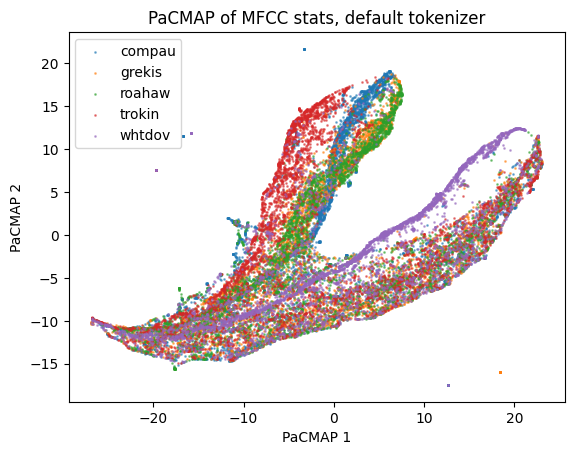

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


def plot_pacman(df, col, title):
    X = np.stack(df[col].values)
    z = pacmap.PaCMAP().fit_transform(X)
    le = LabelEncoder()
    y = le.fit_transform(df.species.values)
    for i, species in enumerate(le.classes_):
        plt.scatter(z[y == i, 0], z[y == i, 1], label=species, alpha=0.5, s=1)
    plt.legend()
    plt.xlabel("PaCMAP 1")
    plt.ylabel("PaCMAP 2")
    plt.title(title)


plot_pacman(df1, "mfcc_stats", "PaCMAP of MFCC stats, default tokenizer")
plt.show()

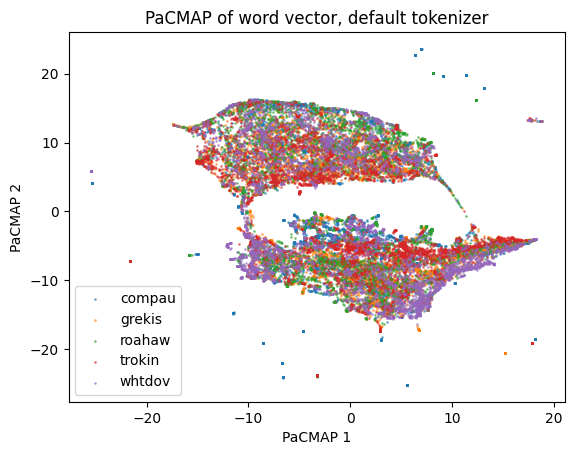

In [41]:
plot_pacman(df1, "word_vector", "PaCMAP of word vector, default tokenizer")
plt.show()

Okay, we actually need a comparison against Perch too because this seems not entirely great...

In [ ]:
shared = Path("~/shared/birdclef").expanduser()
perch = pl.read_parquet(
    f"{shared}/data/2025/train_audio-infer-soundscape/Perch/parts/embed/*.parquet"
)
perch = (
    perch.select(
        "file",
        "start_time",
        "end_time",
        (
            pl.concat_list(perch.columns[3:])
            .list.to_array(len(perch.columns[3:]))
            .alias("embedding")
        ),
    )
    .sort("file", "start_time")
    .with_columns(
        species=pl.col("file").str.split("/").list.get(-2),
        track=pl.col("file").str.split("/").list.get(-1).str.split(".").list.first(),
    )
)
perch

file,start_time,end_time,embedding,species,track
str,f64,f64,"array[f64, 1280]",str,str
"""/storage/coda1/p-dsgt_clef2025…",0.0,5.0,"[0.035193, 0.312198, … -0.124598]","""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",5.0,10.0,"[-0.049977, -0.035013, … 0.107605]","""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",10.0,15.0,"[-0.012233, -0.025818, … -0.022362]","""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",15.0,20.0,"[-0.027199, -0.029883, … -0.011001]","""1139490""","""CSA36385"""
"""/storage/coda1/p-dsgt_clef2025…",20.0,25.0,"[-0.065667, -0.083267, … -0.023513]","""1139490""","""CSA36385"""
…,…,…,…,…,…
"""/storage/coda1/p-dsgt_clef2025…",15.0,20.0,"[-0.014966, -0.110595, … -0.002384]","""ywcpar""","""iNat819873"""
"""/storage/coda1/p-dsgt_clef2025…",20.0,25.0,"[0.099977, -0.029867, … 0.020116]","""ywcpar""","""iNat819873"""
"""/storage/coda1/p-dsgt_clef2025…",0.0,5.0,"[0.019189, -0.076516, … 0.027332]","""ywcpar""","""iNat922688"""


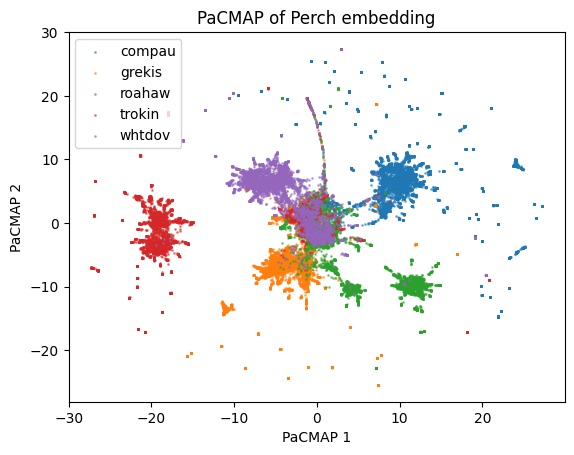

In [ ]:
plot_pacman(
    perch.join(
        top5,
        on="species",
        how="inner",
    )
    .select("species", "embedding")
    .to_pandas(),
    "embedding",
    "PaCMAP of Perch embedding",
)

Let's finish up the PCA tokens and see how those look

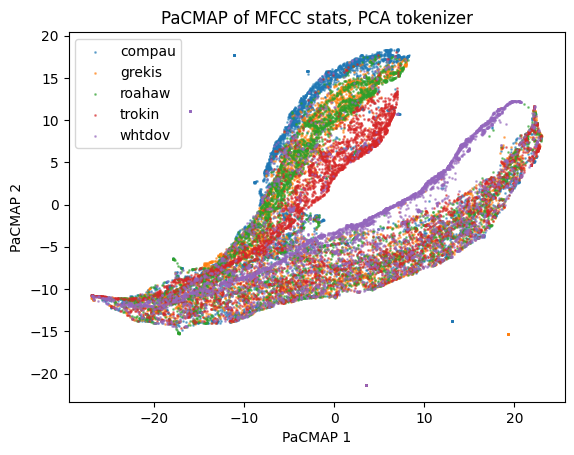

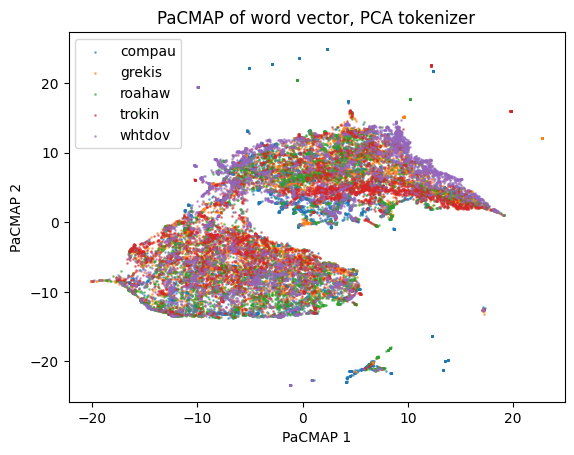

In [52]:
df2 = (
    df.filter(pl.col("tokenizer") == "tokenizer_pca")
    .join(top5, on="species", how="inner")
    .select("species", "mfcc_stats", "word_vector")
    .to_pandas()
)
plot_pacman(df2, "mfcc_stats", "PaCMAP of MFCC stats, PCA tokenizer")
plt.show()
plot_pacman(df2, "word_vector", "PaCMAP of word vector, PCA tokenizer")
plt.show()